# Hands-On Exercise: Clustering – Customer Segmentation with KMeans

This hands-on exercise walks you through performing **customer segmentation** using the **KMeans clustering algorithm** inside **Amazon SageMaker Studio.** You will load a customer dataset, optionally generate synthetic records, scale features, determine the optimal number of clusters using the **Elbow Method**, visualize the segments, and interpret cluster behaviors for real-world business applications such as targeted marketing. This exercise demonstrates **unsupervised learning**, where the goal is to uncover hidden patterns in customer behavior without predefined labels.

## 1. Launch Amazon SageMaker Studio
### 1.1 Open the Amazon SageMaker Console
<ol>
<li>Sign in to the AWS Management Console.</li>
<li>Navigate Amazon SageMaker AI.</li>
<li>In the left pane, click on SageMaker Studio.</li>
</ol>

### 1.2 Launch (or Create) Your SageMaker Domain
If a domain already exists: Click Launch Studio. <br>
If no domain exists:
<ol>
<li>Click Create SageMaker Domain.</li>
<li>Choose Set up for single user.</li>
<li>Accept default settings.</li>
<li>Wait for domain creation to complete.</li>
<li>Click Launch Studio.</li>
<li>Make sure to that user profile has appropriate permissions (for example, PutObject, GetObject, ListBucket etc) for the S3 bucket used in this exercise.
</ol>

### 1.3 Create a New Jupyter Notebook
Inside SageMaker Studio:
<ol>
<li>Select Notebook (Python 3 – Data Science kernel recommended).  </li>
<li>A new notebook environment will open. </li>
<li>Provide a meaningful name </li>
</ol>

### 1.4 Install Required Python Libraries

In [37]:
!pip install -q pandas scikit-learn matplotlib


## 2. Prepare the Dataset (Generate 1,000 Synthetic Records and Upload to S3)
<ol>
<li>Define the original 14-record sample dataset in the notebook.</li>
<li>Use it to generate 1,000 synthetic customer records with similar ranges.</li>
<li>Upload the 1,000-record file to Amazon S3 for use in the rest of the lab.</li>
</ol>

### 2.1 Create the Base Sample Dataset in the Notebook


In [38]:
import pandas as pd

base_data = {
    "CustomerID": [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
    "Age": [19,21,20,23,31,22,35,23,64,30,67,45,52,40],
    "AnnualIncome": [15000,18000,16000,25000,40000,22000,35000,25000,100000,60000,95000,45000,48000,50000],
    "SpendingScore": [39,81,6,77,40,76,6,94,3,72,14,99,10,88]
}

base_df = pd.DataFrame(base_data)
base_df


,CustomerID,Age,AnnualIncome,SpendingScore
0,1,19,15000,39
1,2,21,18000,81
2,3,20,16000,6
3,4,23,25000,77
4,5,31,40000,40
5,6,22,22000,76
6,7,35,35000,6
7,8,23,25000,94
8,9,64,100000,3
9,10,30,60000,72


### 2.2 Generate 1,000 Synthetic Records Based on the Sample

In [39]:
import numpy as np

np.random.seed(42)   # for reproducibility
n_samples = 1000

age_min, age_max = base_df["Age"].min(), base_df["Age"].max()
inc_min, inc_max = base_df["AnnualIncome"].min(), base_df["AnnualIncome"].max()
score_min, score_max = base_df["SpendingScore"].min(), base_df["SpendingScore"].max()

synthetic_df = pd.DataFrame({
    "CustomerID": range(1, n_samples + 1),
    "Age": np.random.randint(age_min, age_max + 1, size=n_samples),
    "AnnualIncome": np.random.randint(inc_min, inc_max + 1, size=n_samples),
    "SpendingScore": np.random.randint(score_min, score_max + 1, size=n_samples),
})

synthetic_df.head(), synthetic_df.shape


(   CustomerID  Age  AnnualIncome  SpendingScore
 0           1   57         19324             98
 1           2   47         91323              7
 2           3   33         24111             88
 3           4   61         53110             49
 4           5   26         31389             36,
 (1000, 4))

### 2.3 Upload the 1,000-Record Dataset to Amazon S3

In [40]:
import boto3

bucket = "knodax-ml-specialty-lab-exercises"      # <YOUR_BUCKET_NAME> e.g., knodax-ml-labs
prefix = "customer-segmentation"
s3_key = f"{prefix}/customer_segmentation.csv"

# Save the 1,000-record dataset in the notebook environment
local_path = "customer_segmentation.csv"
synthetic_df.to_csv(local_path, index=False)

# Upload to S3
s3 = boto3.client("s3")
s3.upload_file(local_path, bucket, s3_key)

print(f"Uploaded 1,000-record dataset to: s3://{bucket}/{s3_key}")


Uploaded 1,000-record dataset to: s3://knodax-ml-specialty-lab-exercises/customer-segmentation/customer_segmentation.csv


## 3. Load the dataset from S3

In [41]:
s3_uri = f"s3://{bucket}/{prefix}/customer_segmentation.csv"
df = pd.read_csv(s3_uri)


## 4. Select Features and Scale Them

In [42]:
from sklearn.preprocessing import StandardScaler

feature_cols = ["Age", "AnnualIncome", "SpendingScore"]
X = df[feature_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5. Determine the Optimal Number of Clusters (Elbow Method)

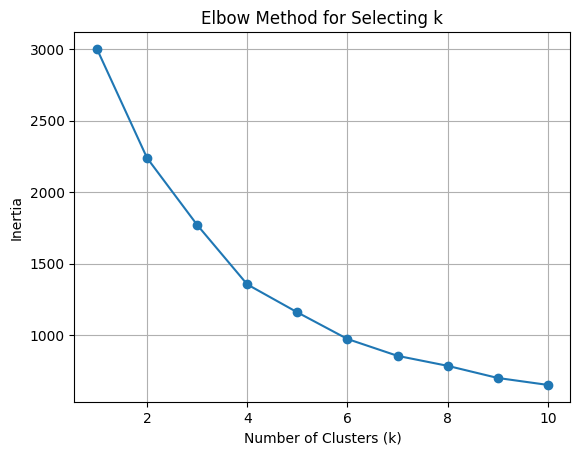

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_values = range(1, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Selecting k")
plt.grid(True)
plt.show()


Select the k value where the curve bends (the “elbow”).
Common choices are 4 or 5.

## 6. Train the KMeans Model

In [49]:
optimal_k = 4  # Update based on the elbow plot

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
kmeans.fit(X_scaled)

df["Cluster"] = kmeans.labels_
df.head()


,CustomerID,Age,AnnualIncome,SpendingScore,Cluster
0,1,57,19324,98,1
1,2,47,91323,7,0
2,3,33,24111,88,1
3,4,61,53110,49,3
4,5,26,31389,36,0


## 7. Visualize Customer Segments

### 7.1 Age vs Spending Score

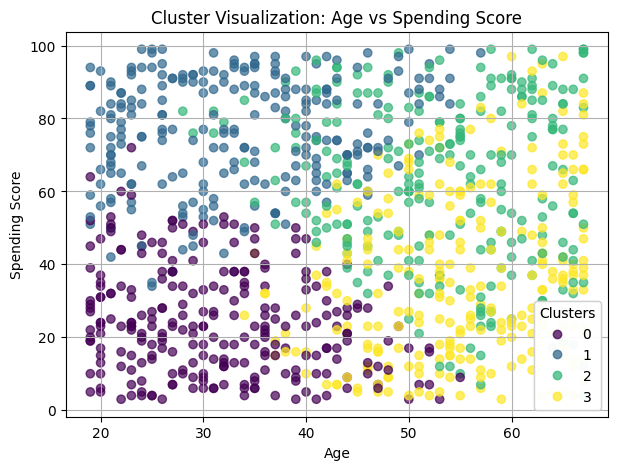

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Scatter plot
scatter = plt.scatter(
    df["Age"],
    df["SpendingScore"],
    c=df["Cluster"],
    cmap="viridis",
    alpha=0.7
)

# Add labels
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.title("Cluster Visualization: Age vs Spending Score")
plt.grid(True)

# Add legend showing cluster colors
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)

plt.show()



### 7.2 Annual Income vs Spending Score (with Color Labels)

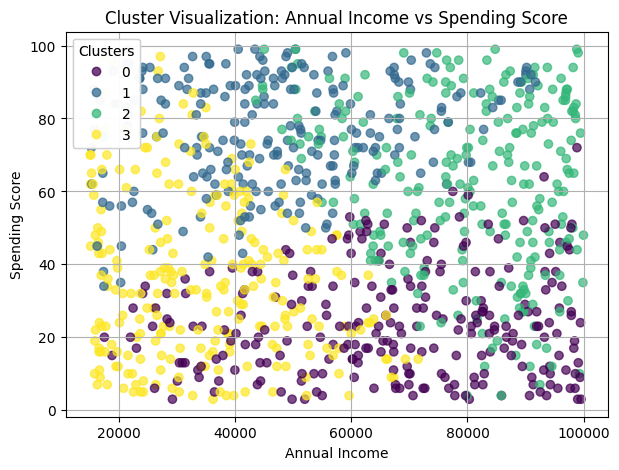

In [46]:
plt.figure(figsize=(7,5))

scatter = plt.scatter(
    df["AnnualIncome"],
    df["SpendingScore"],
    c=df["Cluster"],
    cmap="viridis",
    alpha=0.7
)

plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Cluster Visualization: Annual Income vs Spending Score")
plt.grid(True)

# Add legend showing cluster colors
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)

plt.show()


## 9. Interpret Cluster Behaviors

In [47]:
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

centroid_df = pd.DataFrame(centroids, columns=feature_cols)
centroid_df["Cluster"] = centroid_df.index
centroid_df


,Age,AnnualIncome,SpendingScore,Cluster
0,31.277778,67445.261905,24.246032,0
1,33.429752,47079.987603,76.429752,1
2,53.337302,80282.694444,61.880952,2
3,54.984252,34644.110236,36.673228,3


This table represents the cluster centroids—the average customer profile for each cluster.
Each row summarizes a group of similar customers identified by the KMeans model.

Example interpretations:
<ul>
<li>High income, low spenders → Re-engagement opportunities</li>
<li>Low income, high spenders → Value-driven loyal customers</li>
<li>Young, trend-sensitive customers → Ideal for targeted promotions</li>
<li>Low-spend cluster → Lower priority segment</li>
</ul>

### Cluster 0

Centroid:
<ul>
<li>Age ≈ 31</li>
<li>Annual Income ≈ $67,445<l/i>
<li>Spending Score ≈ 24</li>
</ul>

Interpretation:
<ul>
<li>These customers are young, relatively high-income, but have low spending scores.</li>
<li>They earn well but are not spending much → “High-income low spenders”.</li>
<li>Potential strategy: Re-engagement campaigns or incentives to encourage spending.</li>
</ul>

### Cluster 1

Centroid:
<ul>
<li>Age ≈ 33</li>
<li>Annual Income ≈ $47,080</li>
<li>Spending Score ≈ 76</li>
</ul>

Interpretation:
<ul>
<li>Young-to-mid-age customers with moderate income and very high spending scores.</li>
<li>These are high-value, engaged customers who spend actively.</li>
<li>Strategy: Loyalty programs, VIP offers, early access deals.</li>
</ul>

### Cluster 2

Centroid:
<ul>
<li>Age ≈ 53</li>
<li>Annual Income ≈ $80,283</li>
<li>Spending Score ≈ 62</li>
</ul>

Interpretation:
<ul>
<li>Older, high-income, strong spending tendencies.</li>
<li>Very valuable segment: “Affluent active spenders.”</li>
<li>Strategy: Premium services, exclusive product lines, personalized recommendations.</li>
</ul>

### Cluster 3

Centroid:
<ul>
<li>Age ≈ 55</li>
<li>Annual Income ≈ $34,644</li>
<li>Spending Score ≈ 36</li>
</ul>

Interpretation:
<ul>
<li>Older customers with lower income and moderate-to-low spending scores.</li>
<li>Tend to be cost-conscious, low-to-medium engagement.</li>
<li>Strategy: Discount-based campaigns, budget-oriented offerings, or minimal marketing investment.</li>
</ul>

### Summary Interpretation
Cluster	Description	Business Insight
0	Young, high-income, low spenders	Re-engage, understand barriers to spending
1	Young, moderate-income, high spenders	High-value customers → reward & retain
2	Older, high-income, high spenders	Premium / VIP segment
3	Older, low-income, low spenders	Low engagement → conservative marketing

## 10. Save Final Segments to Amazon S3

In [48]:
output_key = f"{prefix}/customer_segments_k{optimal_k}.csv"
output_uri = f"s3://{bucket}/{output_key}"

df.to_csv("customer_segments.csv", index=False)

s3 = boto3.client("s3")
s3.upload_file("customer_segments.csv", bucket, output_key)

print("Clustered dataset saved to:", output_uri)


Clustered dataset saved to: s3://knodax-ml-specialty-lab-exercises/customer-segmentation/customer_segments_k4.csv
